In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib as joblib

In [2]:
df = pd.read_csv('neusser_data.csv', sep=';', index_col="Zeitpunkt")

In [3]:
df.index =  pd.to_datetime(df.index)

In [4]:
df.head()

,Anzahl
Zeitpunkt,
2017-01-02 07:00:00,3
2017-01-02 08:00:00,6
2017-01-02 09:00:00,15
2017-01-02 10:00:00,19
2017-01-02 11:00:00,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 705 entries, 2017-01-02 07:00:00 to 2017-01-31 15:00:00
Data columns (total 1 columns):
Anzahl    705 non-null int64
dtypes: int64(1)
memory usage: 11.0 KB


NaN-Werte zählen

In [6]:
df.shape

(705, 1)

In [7]:
print("Bußgeld Daten Neusser Str.:\n{}".format(df.head()))

Bußgeld Daten Neusser Str.:
                     Anzahl
Zeitpunkt                  
2017-01-02 07:00:00       3
2017-01-02 08:00:00       6
2017-01-02 09:00:00      15
2017-01-02 10:00:00      19
2017-01-02 11:00:00       0


In [8]:
df_time = df.copy()
df_time['hour'] = df_time.index.hour.values.reshape(-1, 1)
df_time['weekday'] = df_time.index.dayofweek.values.reshape(-1, 1)

C:\Users\JMartens\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Anzahl Bußgelder')

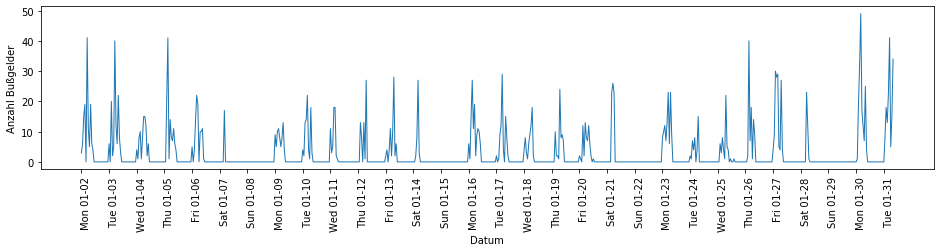

In [9]:
plt.figure(figsize=(16, 3))
xticks = pd.date_range(start=df.index.min(), end=df.index.max(),
                       freq='D')
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(df, linewidth=1)
plt.xlabel("Datum")
plt.ylabel("Anzahl Bußgelder")

In [10]:
# extract the target values (number of rentals)
y = df.values
# convert to POSIX time by dividing by 10**9
X = df.index.astype("int64").values.reshape(-1, 1) // 10**9

In [11]:
n_train = (len(df)/100)*80

In [12]:
n_train

564.0

In [13]:
# use the first 184 data points for training, the rest for testing
n_train = 564

# function to evaluate and plot a regressor on a given feature set
def eval_on_features(features, target, regressor):
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    # also split the target array
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(14, 3))

    plt.xticks(range(0, len(X), 24), xticks.strftime("%a %m-%d"), rotation=90,
               ha="left")

    plt.plot(range(n_train), y_train, label="Trainingsdaten")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="Testdaten")
    plt.plot(range(n_train), y_pred_train, '--', label="Vorhersage Trainingsdaten")

    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--',
             label="Vorhersage Testdaten")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Datum")
    plt.ylabel("Anzahl Bußgelder")
    
    joblib.dump(regressor, 'model.pkl')

C:\Users\JMartens\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


Test-set R^2: -0.07


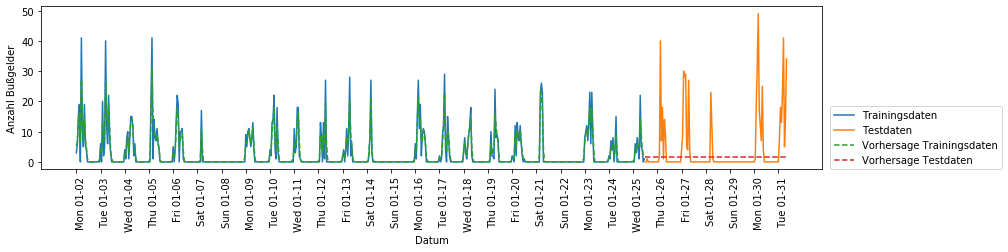

In [14]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor)

C:\Users\JMartens\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


Test-set R^2: 0.33


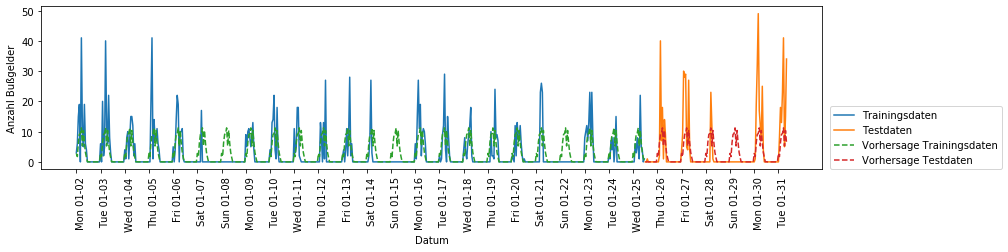

In [15]:
X_hour = df.index.hour.values.reshape(-1, 1)
eval_on_features(X_hour, y, regressor)

C:\Users\JMartens\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


Test-set R^2: 0.47


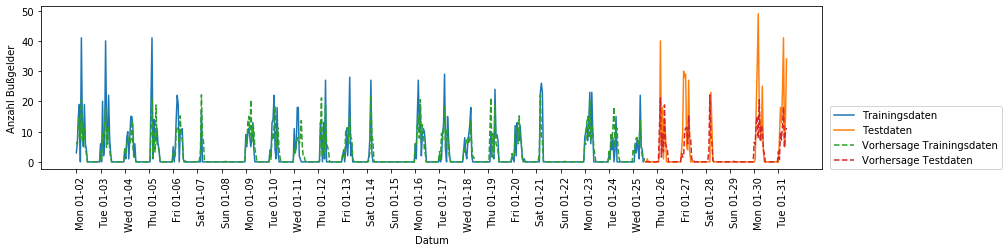

In [24]:
X_hour_week = np.hstack([df.index.dayofweek.values.reshape(-1, 1),
                         df.index.hour.values.reshape(-1, 1)])

X = df_time[['hour','weekday']]
eval_on_features(X, y, regressor)

Test-set R^2: 0.02


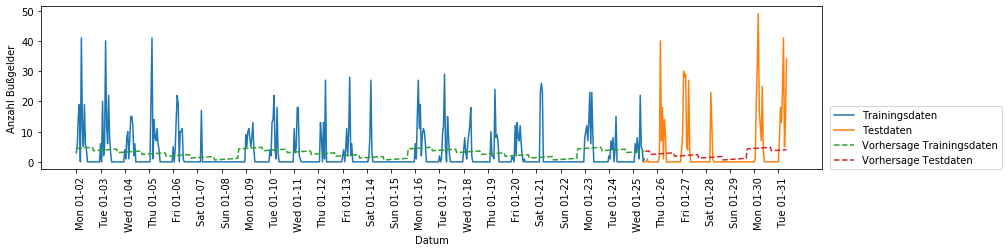

In [17]:
from sklearn.linear_model import LinearRegression, Ridge
eval_on_features(X_hour_week, y, LinearRegression())

C:\Users\JMartens\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Test-set R^2: 0.38


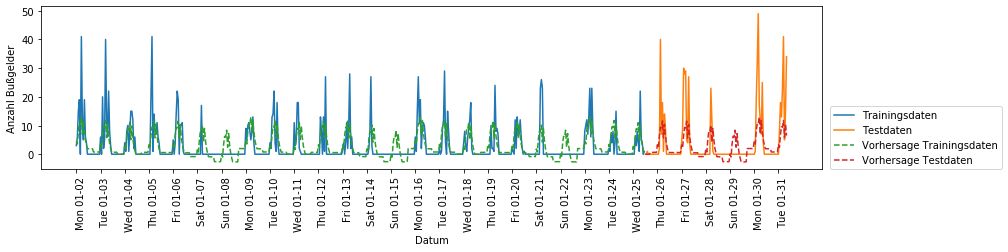

In [18]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()
eval_on_features(X_hour_week_onehot, y, Ridge())

Test-set R^2: 0.46


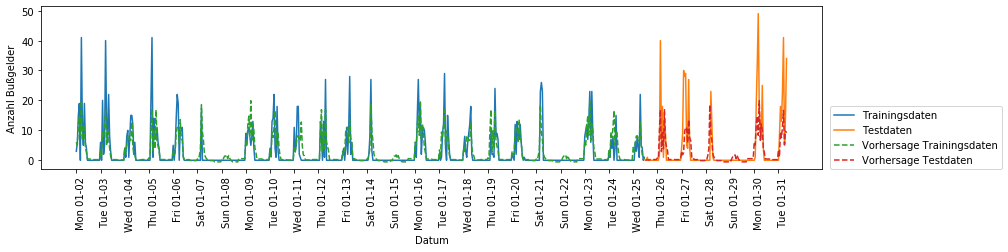

In [19]:
from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(degree=2, interaction_only=True,
                                      include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)


In [20]:
hour = ["%02d:00" % i for i in range(0, 24, 1)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat","Sun"]
features =  day + hour

In [21]:
features_poly = poly_transformer.get_feature_names(features)
features_nonzero = np.array(features_poly)
coef_nonzero = lr.coef_[lr.coef_ != 0]
len(features_poly)

496

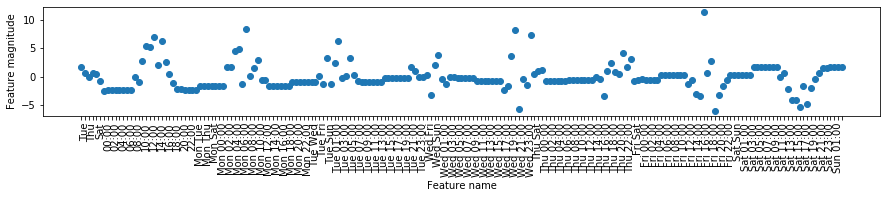

In [22]:
import matplotlib.ticker as plticker

a4_dims = (15, 2)
fig, ax = plt.subplots( figsize=a4_dims)

plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel("Feature name")
plt.ylabel("Feature magnitude")

for label in ax.get_xticklabels()[::2]:
    label.set_visible(False)